In [ ]:
!pip uninstall ndvi_tools -y

In [ ]:
!pip install ndvi_tools/

In [1]:
import os
import json
import xarray as xr
import geopandas as gpd

import datacube
import matplotlib.pyplot as plt
from deafrica_tools.plotting import display_map
from deafrica_tools.dask import create_local_dask_cluster

from ndvi_tools.ndvi_anomaly_plugin import NDVIAnomaly
import warnings
warnings.filterwarnings("ignore")

## Test plugin without odc-stats

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:35251 Dashboard: /user/chad_extra/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [3]:
dc = datacube.Datacube(app="Vegetation_anomalies")

In [4]:
lat, lon = 2.7059,36.9406#31.0004, 29.6856#6.51010,-2.7352#13.6683,-0.99460
lat_buffer = 0.15
lon_buffer = 0.15
# Set the range of dates for the climatology
time_range = ('2021-12')
resolution = (-30, 30)

lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

In [5]:
# display_map(x=lon_range, y=lat_range)

In [6]:
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'resolution': resolution,
    'output_crs':'epsg:6933',
    'measurements':['red','nir'],
    'group_by':'solar_day',
#     'collection_category':'T1'
#     'dask_chunks':dask_chunks
}

### grab data so we can use the geobox parameter to mimic a 'task'

In [7]:
task = dc.load(product=['ls8_sr', 'ls9_sr', 's2_l2a'], dask_chunks={}, **query)

### grab lists of datatsets to mimic .db files

In [8]:
dss = dc.find_datasets(product=['ls8_sr', 'ls9_sr', 's2_l2a'], **query)

### set up an example config

In [9]:
config = dict(
      resampling= "bilinear",
      bands_ls89= ["red", "nir", "green", "blue"],
      bands_s2= ["red", "nir_2"],
      mask_band_ls= "QA_PIXEL",
      mask_band_s2= "SCL",
      rolling_window=3,
      mask_filters= [["opening", 5], ["dilation", 5]]
        )

### Run the plugin code

In [10]:
x=NDVIAnomaly(**config)
ndvi = x.input_data(dss, task.geobox)
result = x.reduce(ndvi)#.compute()
print(result)

<xarray.Dataset>
Dimensions:           (time: 1, y: 1275, x: 966)
Coordinates:
  * time              (time) datetime64[ns] 2021-12-31
  * y                 (y) float64 3.642e+05 3.642e+05 ... 3.26e+05 3.26e+05
  * x                 (x) float64 3.55e+06 3.55e+06 ... 3.579e+06 3.579e+06
    spatial_ref       int32 6933
Data variables:
    ndvi_mean         (time, y, x) float32 dask.array<chunksize=(1, 1275, 966), meta=np.ndarray>
    ndvi_std_anomaly  (time, y, x) float32 dask.array<chunksize=(1, 1275, 966), meta=np.ndarray>
    clear_count       (time, y, x) int8 dask.array<chunksize=(1, 1275, 966), meta=np.ndarray>
Attributes:
    grid_mapping:  spatial_ref


In [11]:
%%time
result = result.compute()

CPU times: user 3.64 s, sys: 255 ms, total: 3.89 s
Wall time: 32.1 s


### Plot

In [ ]:
plt.rcParams["axes.facecolor"] = "gray"  # makes transparent pixels obvious

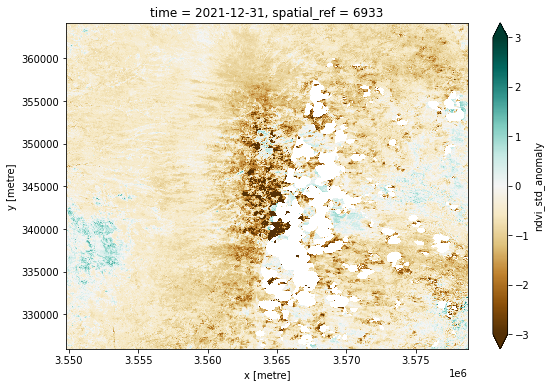

In [12]:
result['ndvi_std_anomaly'].plot(vmin=-3, vmax=3, cmap='BrBG', size=6);

In [ ]:
print(result['ndvi_std_anomaly'].min().values)
print(result['ndvi_std_anomaly'].mean().values)
print(result['ndvi_std_anomaly'].max().values)
result['ndvi_std_anomaly'].plot.hist(bins=500);
plt.xlim(-4,4);

In [ ]:
print(result['ndvi_mean'].min().values)
print(result['ndvi_mean'].mean().values)
print(result['ndvi_mean'].max().values)
result['ndvi_mean'].plot.hist(bins=500);
plt.xlim(-0.5,1);

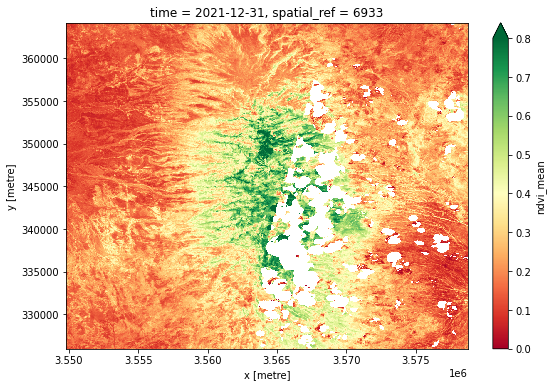

In [13]:
result['ndvi_mean'].plot(size=6, vmax=0.8, vmin=0, cmap='RdYlGn');

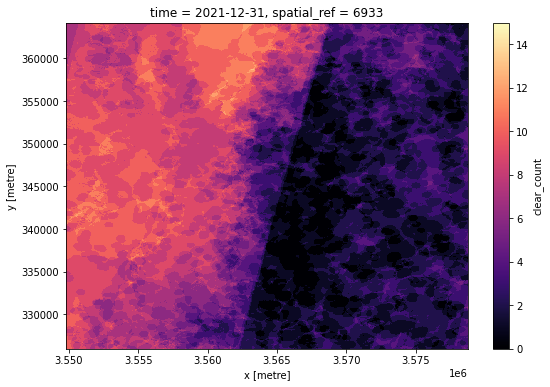

In [14]:
result['clear_count'].plot(size=6, vmax=15, vmin=0, cmap='magma');

-----

# Test plugin with odc-stats

In [ ]:
# !pip uninstall ndvi_tools -y

In [ ]:
# !pip install ndvi_tools/

In [ ]:
import os
import json
import xarray as xr
import geopandas as gpd
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct

### Generate tasks etc

In [ ]:
time_range = '2021-12--P1M'

In [ ]:
os.system("odc-stats save-tasks "\
          "--grid africa_30 "\
          "--temporal-range "+time_range + " ls8_sr-ls9_sr-s2_l2a")
#--dataset-filter '{"collection_category": "T1"}'

In [ ]:
# os.system("cm-task --task-csv=ls5_sr-ls7_sr-ls8_sr_2011--P5Y.csv "\
#           "--geojson=../testing/data/testing_extent.geojson "\
#           "--outfile=aez.csv "\
#           "--grid=africa_30 " \
#           "--sqs=deafrica-dev-eks-stats-ndvi-clim "\
#           "--db=ls5_sr-ls7_sr-ls8_sr_2011--P5Y.db "\
#          )

### Enter the X and Y Tile ID of the tile you want to run

Use the geojson to select a tile id

In [ ]:
tile_x = '214' #x173y118 x179/y094 202,034
tile_y = '079'  	

t=[int(tile_x), int(tile_y)]

### Extract the tasks object for that tile

In [ ]:
name, version = 'ndvi_anomaly', '1-0-0'
op = OutputProduct(
            name='ndvi_anomaly_ls',
            version='1-0-0',
            short_name='ndvi_anomaly_ls',
            location=f"s3://dummy-bucket/{name}/{version}",
            properties={"odc:file_format": "GeoTIFF"},
            measurements=['red']
        )

taskdb = TaskReader('ls8_sr-ls9_sr-s2_l2a_'+time_range+'.db', product=op)
task = taskdb.load_task((time_range, t[0], t[1]))

### Optionally export tile geojson to view

In [ ]:
# with open('task_tile_check.geojson', 'w') as fh:
#     json.dump(task.geobox.extent.to_crs('epsg:4326').json, fh, indent=2)

### Find the index of the tile we want to run

In [ ]:
tile_index_to_run = []
all_tiles = list(taskdb.all_tiles)
for i, index in zip(all_tiles, range(0, len(all_tiles))):
    if (i[1]==t[0]) & (i[2]==t[1]):
        tile_index_to_run.append(index)
        print(index)

### Try running odc-stats using the config yaml and external plugin

In [ ]:
%%time
os.system("odc-stats run "\
          "ls8_sr-ls9_sr-s2_l2a_"+time_range+".db "\
          "--config=///home/jovyan/git/ndvi-anomalies/production/ndvi_tools/config/ndvi_anomaly.yaml "\
          "--resolution=120 "\
          "--threads=4 "\
          "--memory-limit=25Gi "\
          "--location=file:///home/jovyan/git/ndvi-anomalies/production/{product}/{version}/ "+str(tile_index_to_run[0])
         )

In [ ]:
# !odc-stats run ls7_sr-ls8_sr_2014--P2Y.db --config=ndvi_climatology.yaml --resolution=80 --threads=4 --memory-limit=29Gi --location=file:///home/jovyan/git/deafrica-sandbox-notebooks/frica-sandbox-notebooks/HLS/{product}/{version} 1202

### Plot results

In [ ]:
a= 'x'+str(t[0])
b='y0'+str(t[1])

anom=xr.open_rasterio('ndvi_anomaly/1-0-0/'+a+'/'+b+'/'+time_range+'/ndvi_anomaly_'+a+b+'_'+time_range+'_ndvi_std_anomaly.tif').squeeze()
print(anom)
anom.squeeze().plot.imshow(size=6, vmax=3, vmin=-3, cmap='BrBG');

In [ ]:
mean=xr.open_rasterio('ndvi_anomaly/1-0-0/'+a+'/'+b+'/'+time_range+'/ndvi_anomaly_'+a+b+'_'+time_range+'_ndvi_mean.tif').squeeze()
print(mean)
mean.squeeze().plot.imshow(size=6, vmax=0.9, vmin=0, cmap='RdYlGn');

In [ ]:
count=xr.open_rasterio('ndvi_anomaly/1-0-0/'+a+'/'+b+'/'+time_range+'/ndvi_anomaly_'+a+b+'_'+time_range+'_clear_count.tif').squeeze()
print(count)
count.squeeze().plot.imshow(size=6, vmax=15, vmin=0, cmap='magma');

### remove results folder

In [ ]:
!rm -r -f ndvi_anomaly/

## Sync folder from s3

In [ ]:
!aws s3 sync s3://deafrica-data-dev-af/ndvi_anomaly ndvi_anomaly  --no-sign-request